In [99]:
import tensorflow as tf
import tensorflow.keras as keras
import os
import sys
from importlib import reload
module_path = os.path.abspath(os.path.join('../..'))
if module_path not in sys.path:
    sys.path.append(module_path)
import probdownscale
reload(probdownscale.TaskExtractor)
reload(probdownscale.MetaTrain)
from probdownscale.MetaTrain import MetaSGD

from probdownscale.TaskExtractor import TaskExtractor
import math
import numpy as np
import netCDF4 as nc

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Model
from tensorflow_probability import distributions as tfd
from matplotlib import pyplot as plt

## 1. Debug TaskExtractor

In [2]:
file_path_g_05 = r'C:\Users\96349\Documents\Downscale_data\MERRA2\G5NR_aerosol_variables_over_MiddleEast_daily_20050516-20060515.nc'
file_path_g_06 =  r'C:\Users\96349\Documents\Downscale_data\MERRA2\G5NR_aerosol_variables_over_MiddleEast_daily_20060516-20070515.nc'
file_path_m = r'C:\Users\96349\Documents\Downscale_data\MERRA2\MERRA2_aerosol_variables_over_MiddleEast_daily_20000516-20180515.nc'
target_var = 'BCSMASS'

# read data
g05_data = nc.Dataset(file_path_g_05)
g06_data = nc.Dataset(file_path_g_06)
m_data_nc = nc.Dataset(file_path_m)

# define lat&lon of MERRA, G5NR and mete
M_lons = m_data_nc.variables['lon'][:15]
# self.M_lons = (M_lons-M_lons.mean())/M_lons.std()
M_lats = m_data_nc.variables['lat'][:15]
# self.M_lats = (M_lats-M_lats.mean())/M_lats.std()
G_lons = g05_data.variables['lon'][:30]
# self.G_lons = (G_lons-G_lons.mean())/G_lons.std()
G_lats = g05_data.variables['lat'][:30]

# extract target data
g_data = np.concatenate((g05_data.variables[target_var][:, :30, :30], g06_data.variables[target_var][:, :30, :30]), axis=0)
m_data = m_data_nc.variables[target_var][5*365:7*365, :15, :15]

C:\Users\96349\anaconda3\envs\Downscale_env\lib\site-packages\ipykernel_launcher.py:12: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  if sys.path[0] == '':
C:\Users\96349\anaconda3\envs\Downscale_env\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  
C:\Users\96349\anaconda3\envs\Downscale_env\lib\site-packag

In [96]:
train_g_data, test_g_data = g_data[:657], g_data[657:]
train_m_data, test_m_data = m_data[:657], m_data[657:]
data = [train_g_data, train_m_data]
lats_lons = [G_lats, G_lons, M_lats, M_lons]
task_dim = 3
test_proportion = 0.3
n_lag = 10
taskextractor = TaskExtractor(data, lats_lons, task_dim, test_proportion, n_lag)

In [84]:
train_x, train_y, test_x, test_y, location = taskextractor._get_one_random_task(return_init=False)

In [97]:
train_x, train_y, test_x, test_y, locations = taskextractor.get_random_tasks(10)


In [35]:
train_x, train_y, test_x, test_y, locations = taskextractor.get_random_tasks(locations=locations[:4])

In [98]:
taskextractor.get_seen()

{(12.0625, 25.75): 1,
 (11.75, 26.5): 1,
 (12.375, 25.8125): 1,
 (10.9375, 27.3125): 1,
 (11.375, 25.875): 1,
 (11.6875, 26.0625): 1,
 (11.125, 26.4375): 1,
 (11.875, 27.0625): 1,
 (12.625, 25.9375): 1,
 (12.0625, 26.9375): 1}

In [99]:
a = list(range(10))
a

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]

In [100]:
a[6:9]

[6, 7, 8]

## 2. Test Network

In [61]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Model
from tensorflow_probability import distributions as tfd

In [49]:
# the last channel is the comonents
alpha = np.random.rand(5)
alpha = alpha/alpha.sum()
mu = np.random.rand(3, 2, 5)
mu = np.abs(mu)
test_md = tfd.MixtureSameFamily(
        mixture_distribution=tfd.Categorical(probs=alpha),
        components_distribution=tfd.Gamma(concentration=mu, rate=mu))

In [51]:
test_md.variance()

<tf.Tensor: shape=(3, 2), dtype=float64, numpy=
array([[ 7.44577378, 12.65164306],
       [ 7.45454975,  4.21166889],
       [ 6.20041569,  3.6764311 ]])>

In [221]:
test_md.sample(100).numpy().mean(axis=0)

array([[0.96121876, 0.84317056],
       [0.9761822 , 0.81684038],
       [0.99552519, 0.81038832]])

In [231]:
log_like = test_md.log_prob(np.ones((3,2)))
#-tf.reduce_mean(log_like, axis=-1)
log_like

# when the Y is really small, log_prob return a positive log likelihood

<tf.Tensor: shape=(3, 2), dtype=float64, numpy=
array([[-1.54147116, -1.3535997 ],
       [-1.3061699 , -1.69724539],
       [-1.56801883, -1.40614818]])>

In [313]:
test_md.mean()

<tf.Tensor: shape=(3, 2), dtype=float64, numpy=
array([[0.15880819, 0.10569395],
       [0.17997603, 0.15908541],
       [0.20016422, 0.19627221]])>

In [80]:
log_like

<tf.Tensor: shape=(3, 2), dtype=float64, numpy=
array([[-1.07151844, -1.96976935],
       [-0.88054633, -1.06112697],
       [-1.63395563, -0.41498473]])>

In [160]:
a =  np.random.rand(3,3,3)
#a = (a - a.min())/(a.max() - a.min())
a = a/a.sum()
a.sum()

1.0

In [106]:
# define necessary tool functions
components = 100
no_parameters = 2

def nnelu(input):
    return tf.add(tf.constant(1, dtype=tf.float32), tf.nn.elu(input))

def slice_parameter_vectors(parameter_vector):
    return [parameter_vector[:, i*components:(i+1)*components] for i in range(3*3*3)]

def gamma_loss(y, parameter_vector):
    a1, a2, a3, a4, a5, a6, a7, a8, a9, m1, m2, m3, m4, m5, m6, m7, m8, m9, s1, s2, s3, s4, s5, s6, s7, s8, s9 = slice_parameter_vectors(parameter_vector)  # Unpack parameter vectors
    
    gm1 = tfd.MixtureSameFamily(
        mixture_distribution=tfd.Categorical(probs=a1),
        components_distribution=tfd.Gamma(
        concentration=m1, rate=s1)
    )
    gm2 = tfd.MixtureSameFamily(
        mixture_distribution=tfd.Categorical(probs=a2),
        components_distribution=tfd.Gamma(
        concentration=m2, rate=s2)
    )
    gm3 = tfd.MixtureSameFamily(
        mixture_distribution=tfd.Categorical(probs=a3),
        components_distribution=tfd.Gamma(
        concentration=m3, rate=s3)
    )
    gm4 = tfd.MixtureSameFamily(
        mixture_distribution=tfd.Categorical(probs=a4),
        components_distribution=tfd.Gamma(
        concentration=m4, rate=s4)
    )
    gm5 = tfd.MixtureSameFamily(
        mixture_distribution=tfd.Categorical(probs=a5),
        components_distribution=tfd.Gamma(
        concentration=m5, rate=s5)
    )
    gm6 = tfd.MixtureSameFamily(
        mixture_distribution=tfd.Categorical(probs=a6),
        components_distribution=tfd.Gamma(
        concentration=m6, rate=s6)
    )
    gm7 = tfd.MixtureSameFamily(
        mixture_distribution=tfd.Categorical(probs=a7),
        components_distribution=tfd.Gamma(
        concentration=m7, rate=s7)
    )
    gm8 = tfd.MixtureSameFamily(
        mixture_distribution=tfd.Categorical(probs=a8),
        components_distribution=tfd.Gamma(
        concentration=m8, rate=s8)
    )    
    gm9 = tfd.MixtureSameFamily(
        mixture_distribution=tfd.Categorical(probs=a9),
        components_distribution=tfd.Gamma(
        concentration=m9, rate=s9)
    )
    '''
    mae = tf.keras.losses.MeanAbsoluteError()
    all_result = tf.concat([gm1.mean(), gm2.mean(), gm3.mean(), gm4.mean(), gm5.mean(), gm6.mean(), gm7.mean(), gm8.mean(), gm9.mean()], axis=0)
    all_result = tf.reshape(all_result, (tf.shape(a1)[0], 3, 3))
    avg_loss = mae(all_result, y)
    '''
    l1 = -tf.reduce_mean(gm1.log_prob(y[:, 0, 0]), axis=-1)
    l2 = -tf.reduce_mean(gm1.log_prob(y[:, 0, 1]), axis=-1)
    l3 = -tf.reduce_mean(gm1.log_prob(y[:, 0, 2]), axis=-1)
    l4 = -tf.reduce_mean(gm1.log_prob(y[:, 1, 0]), axis=-1)
    l5 = -tf.reduce_mean(gm1.log_prob(y[:, 1, 1]), axis=-1)
    l6 = -tf.reduce_mean(gm1.log_prob(y[:, 1, 2]), axis=-1)
    l7 = -tf.reduce_mean(gm1.log_prob(y[:, 2, 0]), axis=-1)
    l8 = -tf.reduce_mean(gm1.log_prob(y[:, 2, 1]), axis=-1)
    l9 = -tf.reduce_mean(gm1.log_prob(y[:, 2, 2]), axis=-1)
    return tf.reduce_mean([l1, l2, l3, l4, l5, l6, l7, l8, l9])
    '''
    return tf.add(tf.reduce_mean([l1, l2, l3, l4, l5, l6, l7, l8, l9]),
                  tf.reduce_mean([gm1.variance(), gm2.variance(), gm3.variance(), gm4.variance(), 
                                  gm5.variance(), gm6.variance(), gm7.variance(), gm8.variance(), gm9.variance(), ]))
    '''

tf.keras.utils.get_custom_objects().update({'nnelu': layers.Activation(nnelu)})

def plot_history(history, title):
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title(title)
    
def model_generator():
    # define MDN Exponentialmodel
    # input dim (time, channel, rows, cols)
    input1 = layers.Input(shape=(n_lag, 1, task_dim, task_dim)) 
    input1 = layers.BatchNormalization()(input1)
    input2 = layers.Input(shape=(task_dim, task_dim, 1))
    input2 = layers.BatchNormalization()(input2)
    input3 = layers.Input(shape=(1))
    input3 = layers.BatchNormalization()(input3)

    X = layers.ConvLSTM2D(filters=20, kernel_size=(1,2), activation='tanh', return_sequences=True)(input1)
    X = layers.ConvLSTM2D(filters=20, kernel_size=(1,2), activation='relu', return_sequences=True)(X)
    X = layers.ConvLSTM2D(filters=20, kernel_size=(1,1), activation='relu')(X)
    X = layers.Flatten()(X)
    X = layers.Dense(512, activation='relu')(X)
    X = layers.BatchNormalization()(X)
    X = layers.Dense(300, activation='relu')(X)

    X1 = layers.Conv2D(20, (2,2), activation='tanh')(input2)
    X1 = layers.Flatten()(X1)
    X2 = layers.BatchNormalization()(input3)

    X = layers.Concatenate()([X, X1, X2])
    X = layers.Dense(128, activation='relu')(X)
    X = layers.BatchNormalization()(X)
    X = layers.Dense(128, activation='relu')(X)
    X = layers.BatchNormalization()(X)
    alphas1 = layers.Dense(components, activation="softmax")(X)
    alphas2 = layers.Dense(components, activation="softmax")(X)
    alphas3 = layers.Dense(components, activation="softmax")(X)
    alphas4 = layers.Dense(components, activation="softmax")(X)
    alphas5 = layers.Dense(components, activation="softmax")(X)
    alphas6 = layers.Dense(components, activation="softmax")(X)
    alphas7 = layers.Dense(components, activation="softmax")(X)
    alphas8 = layers.Dense(components, activation="softmax")(X)
    alphas9 = layers.Dense(components, activation="softmax")(X)
    mus1 = layers.Dense(components, activation='nnelu')(X)
    mus2 = layers.Dense(components, activation='nnelu')(X)
    mus3 = layers.Dense(components, activation='nnelu')(X)
    mus4 = layers.Dense(components, activation='nnelu')(X)
    mus5 = layers.Dense(components, activation='nnelu')(X)
    mus6 = layers.Dense(components, activation='nnelu')(X)
    mus7 = layers.Dense(components, activation='nnelu')(X)
    mus8 = layers.Dense(components, activation='nnelu')(X)
    mus9 = layers.Dense(components, activation='nnelu')(X)
    sigmas1 = layers.Dense(components, activation='nnelu')(X)
    sigmas2 = layers.Dense(components, activation='nnelu')(X)
    sigmas3 = layers.Dense(components, activation='nnelu')(X)
    sigmas4 = layers.Dense(components, activation='nnelu')(X)
    sigmas5 = layers.Dense(components, activation='nnelu')(X)
    sigmas6 = layers.Dense(components, activation='nnelu')(X)
    sigmas7 = layers.Dense(components, activation='nnelu')(X)
    sigmas8 = layers.Dense(components, activation='nnelu')(X)
    sigmas9 = layers.Dense(components, activation='nnelu')(X)
    output = layers.Concatenate()([alphas1,  alphas2, alphas3, alphas4, alphas5, alphas6, alphas7, alphas8, alphas9, 
                                                               mus1,  mus2,  mus3,  mus4,  mus5,  mus6,  mus7,  mus8,  mus9, 
                                                               sigmas1,  sigmas2, sigmas3, sigmas4, sigmas5, sigmas6, sigmas7, sigmas8, sigmas9,])
    model = Model([input1, input2, input3], output)
    return model

Epoch 1/50
15/15 [==============================] - 17s 135ms/step - loss: 123.1448 - val_loss: 122.8864 - lr: 0.0010
Epoch 2/50
15/15 [==============================] - 0s 30ms/step - loss: 28.5507 - val_loss: 117.5929 - lr: 0.0010
Epoch 3/50
15/15 [==============================] - 0s 30ms/step - loss: 20.5919 - val_loss: 120.5214 - lr: 0.0010
Epoch 4/50
15/15 [==============================] - 0s 30ms/step - loss: 18.3711 - val_loss: 118.5793 - lr: 0.0010
Epoch 5/50
15/15 [==============================] - 0s 30ms/step - loss: 17.4290 - val_loss: 113.7974 - lr: 0.0010
Epoch 6/50
15/15 [==============================] - 0s 30ms/step - loss: 16.8724 - val_loss: 108.0540 - lr: 0.0010
Epoch 7/50
15/15 [==============================] - 0s 30ms/step - loss: 16.8763 - val_loss: 102.6829 - lr: 1.0000e-04
Epoch 8/50
15/15 [==============================] - 0s 30ms/step - loss: 16.7989 - val_loss: 97.7708 - lr: 1.0000e-04
Epoch 9/50
15/15 [==============================] - 0s 30ms/step - los

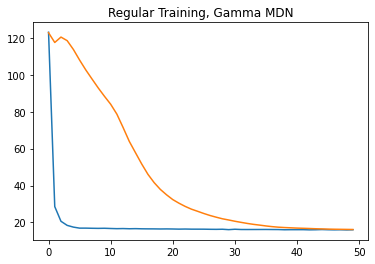

In [55]:
# define MDN Gamma model
MDN_model_ref_gamma = model_generator()
#MDN_model_ref_gamma.set_weights(meta_learner.meta_model.get_weights())
MDN_model_ref_gamma.compile(optimizer=tf.keras.optimizers.Adam(0.001), loss=gamma_loss)
def scheduler(epoch, lr):
    if epoch <= 5:
        return lr
    elif epoch <= 30 and epoch > 5:
        return 0.0001
    else:
        return 0.00005
callback = tf.keras.callbacks.LearningRateScheduler(scheduler)
history_gamma = MDN_model_ref_gamma.fit(train_x, train_y, epochs=50, validation_data=[test_x, test_y], callbacks=callback)
plot_history(history_gamma, 'Regular Training, Gamma MDN')

In [56]:
y_hat = MDN_model_ref_gamma.predict(test_x)
a1, a2, a3, a4, a5, a6, a7, a8, a9, m1, m2, m3, m4, m5, m6, m7, m8, m9, s1, s2, s3, s4, s5, s6, s7, s8, s9  = slice_parameter_vectors(y_hat)
gm1 = tfd.MixtureSameFamily(
        mixture_distribution=tfd.Categorical(probs=a1),
        components_distribution=tfd.Gamma(
        concentration=m1, rate=s1)
    )
gm2 = tfd.MixtureSameFamily(
        mixture_distribution=tfd.Categorical(probs=a2),
        components_distribution=tfd.Gamma(
        concentration=m2, rate=s2)
    )
gm3 = tfd.MixtureSameFamily(
        mixture_distribution=tfd.Categorical(probs=a3),
        components_distribution=tfd.Gamma(
        concentration=m3, rate=s3)
    )
gm4 = tfd.MixtureSameFamily(
        mixture_distribution=tfd.Categorical(probs=a4),
        components_distribution=tfd.Gamma(
        concentration=m4, rate=s4)
    )
gm5 = tfd.MixtureSameFamily(
        mixture_distribution=tfd.Categorical(probs=a5),
        components_distribution=tfd.Gamma(
        concentration=m5, rate=s5)
    )
gm6 = tfd.MixtureSameFamily(
        mixture_distribution=tfd.Categorical(probs=a6),
        components_distribution=tfd.Gamma(
        concentration=m6, rate=s6)
    )
gm7 = tfd.MixtureSameFamily(
        mixture_distribution=tfd.Categorical(probs=a7),
        components_distribution=tfd.Gamma(
        concentration=m7, rate=s7)
    )
gm8 = tfd.MixtureSameFamily(
    mixture_distribution=tfd.Categorical(probs=a8),
        components_distribution=tfd.Gamma(
        concentration=m8, rate=s8)
    )    
gm9 = tfd.MixtureSameFamily(
        mixture_distribution=tfd.Categorical(probs=a9),
        components_distribution=tfd.Gamma(
        concentration=m9, rate=s9)
    )

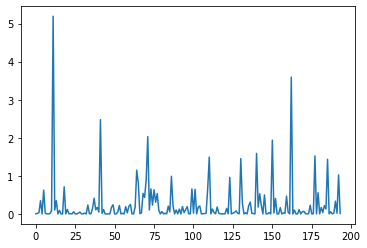

(array([167.,  16.,   5.,   3.,   1.,   0.,   1.,   0.,   0.,   1.]),
 array([1.1480076e-25, 5.1916409e-01, 1.0383282e+00, 1.5574923e+00,
        2.0766563e+00, 2.5958204e+00, 3.1149845e+00, 3.6341486e+00,
        4.1533127e+00, 4.6724768e+00, 5.1916409e+00], dtype=float32),
 <BarContainer object of 10 artists>)

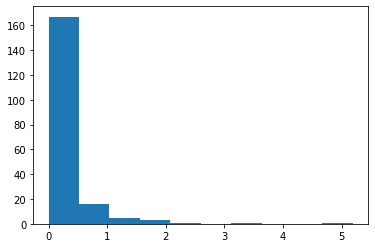

In [62]:
pred = np.mean(gm2.sample(1).numpy(), axis=0)
plt.plot(pred)
plt.show()
plt.hist(pred)

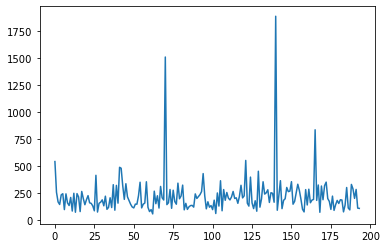

(array([133.,  52.,   6.,   0.,   1.,   0.,   0.,   1.,   0.,   1.]),
 array([  59.53921066,  241.98668282,  424.43415498,  606.88162714,
         789.32909931,  971.77657147, 1154.22404363, 1336.67151579,
        1519.11898796, 1701.56646012, 1884.01393228]),
 <BarContainer object of 10 artists>)

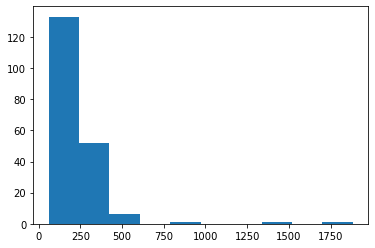

In [60]:
plt.plot(test_y[:, 0, 1])
plt.show()
plt.hist(test_y[:, 0, 1])

In [33]:
pred = np.array([gm1.mean()[0], gm2.mean()[0], gm3.mean()[0], gm4.mean()[0], gm5.mean()[0], gm6.mean()[0], gm7.mean()[0], gm8.mean()[0], gm9.mean()[0]])
pred = pred.reshape((3, 3))
pred = (pred - pred.min())/(pred.max() - pred.min())
true = test_y[0]
true = (true - true.min())/(true.max() - true.min())
np.mean(np.abs(pred - true))

0.5288835981993701

The MAE between mean of MD and Y is not a stable loss to track.

## 3. Debug Meta Learning Algorithm

In [231]:
reload(probdownscale.MetaTrain)
from probdownscale.MetaTrain import MetaSGD

# define necessary tool functions
components = 100
no_parameters = 3
data = [train_g_data, train_m_data]
lats_lons = [G_lats, G_lons, M_lats, M_lons]
task_dim = 3
test_proportion = 0.5
n_lag = 10

MDN_model = model_generator()

# define TaskExtractor

taskextractor = TaskExtractor(data, lats_lons, task_dim, test_proportion, n_lag)

# define meta learner
meta_optimizer = tf.keras.optimizers.Adam(0.0001)
inner_step = 1
inner_optimizer = tf.keras.optimizers.Adam(0.0001)

meta_learner = MetaSGD(MDN_model, gamma_loss,  meta_optimizer, inner_step, inner_optimizer, taskextractor, meta_lr=0.001)


$\beta = lr\times e^{-\bar{Cov}}\times (e^{(b/s)^{0.5}}-1)$

In [229]:
0.5**0.1

0.9330329915368074

covariance factor: 0.7154835175546712
batch size factor: 1.718281828459045
Meta lr: <tf.Variable 'learning_rate:0' shape=() dtype=float32, numpy=0.0012294024>
Epoch: 1 / 10  Basic training step:  1 / 8 loss:  32.79431
covariance factor: 0.7525019391642964
batch size factor: 1.5422079918208849
Meta lr: <tf.Variable 'learning_rate:0' shape=() dtype=float32, numpy=0.0007736585>
Epoch: 1 / 10  Basic training step:  2 / 8 loss:  29.129059
covariance factor: 0.7775011477369007
batch size factor: 1.449682587009316
Meta lr: <tf.Variable 'learning_rate:0' shape=() dtype=float32, numpy=0.0006074711>
Epoch: 1 / 10  Basic training step:  3 / 8 loss:  25.068172
covariance factor: 0.7686410301642882
batch size factor: 1.3882253608578883
Meta lr: <tf.Variable 'learning_rate:0' shape=() dtype=float32, numpy=0.0004986338>
Epoch: 1 / 10  Basic training step:  4 / 8 loss:  21.636108
covariance factor: 0.7795515870531867
batch size factor: 1.3427838986640035
Meta lr: <tf.Variable 'learning_rate:0' shape=(

covariance factor: 0.8180543961784151
batch size factor: 1.0716671210192974
Meta lr: <tf.Variable 'learning_rate:0' shape=() dtype=float32, numpy=0.0001861078>
Epoch: 3 / 10  Basic training step:  2 / 8 loss:  9.2460985
covariance factor: 0.8233567426020918
batch size factor: 1.0716671210192974
Meta lr: <tf.Variable 'learning_rate:0' shape=() dtype=float32, numpy=0.0001873141>
Epoch: 3 / 10  Basic training step:  3 / 8 loss:  10.345139
covariance factor: 0.8190132927671052
batch size factor: 1.0716671210192974
Meta lr: <tf.Variable 'learning_rate:0' shape=() dtype=float32, numpy=0.00018632597>
Epoch: 3 / 10  Basic training step:  4 / 8 loss:  9.637252
covariance factor: 0.825030691811471
batch size factor: 1.0716671210192974
Meta lr: <tf.Variable 'learning_rate:0' shape=() dtype=float32, numpy=0.00018769492>
Epoch: 3 / 10  Basic training step:  5 / 8 loss:  10.021298
covariance factor: 0.8217125879997568
batch size factor: 1.0716671210192974
Meta lr: <tf.Variable 'learning_rate:0' shap

covariance factor: 0.8439388184221224
batch size factor: 1.0102265285674745
Meta lr: <tf.Variable 'learning_rate:0' shape=() dtype=float32, numpy=0.00015236926>
Epoch: 5 / 10  Basic training step:  4 / 8 loss:  8.227309
covariance factor: 0.8475936136429476
batch size factor: 1.0102265285674745
Meta lr: <tf.Variable 'learning_rate:0' shape=() dtype=float32, numpy=0.00015302912>
Epoch: 5 / 10  Basic training step:  5 / 8 loss:  8.727991
covariance factor: 0.8430399082305869
batch size factor: 1.0102265285674745
Meta lr: <tf.Variable 'learning_rate:0' shape=() dtype=float32, numpy=0.00015220698>
Epoch: 5 / 10  Basic training step:  6 / 8 loss:  8.362554
covariance factor: 0.86116082750783
batch size factor: 1.0102265285674745
Meta lr: <tf.Variable 'learning_rate:0' shape=() dtype=float32, numpy=0.00015547863>
Epoch: 5 / 10  Basic training step:  7 / 8 loss:  7.9701767
covariance factor: 0.8598044500693223
batch size factor: 1.0102265285674745
Meta lr: <tf.Variable 'learning_rate:0' shape

covariance factor: 0.8607768804168191
batch size factor: 0.9767664503773086
Meta lr: <tf.Variable 'learning_rate:0' shape=() dtype=float32, numpy=0.00013627105>
Epoch: 7 / 10  Basic training step:  5 / 8 loss:  8.081879
covariance factor: 0.857137076040918
batch size factor: 0.9767664503773086
Meta lr: <tf.Variable 'learning_rate:0' shape=() dtype=float32, numpy=0.00013569482>
Epoch: 7 / 10  Basic training step:  6 / 8 loss:  7.7298307
covariance factor: 0.8723858246148523
batch size factor: 0.9767664503773086
Meta lr: <tf.Variable 'learning_rate:0' shape=() dtype=float32, numpy=0.00013810888>
Epoch: 7 / 10  Basic training step:  7 / 8 loss:  7.4247894
covariance factor: 0.8711512837364237
batch size factor: 0.9767664503773086
Meta lr: <tf.Variable 'learning_rate:0' shape=() dtype=float32, numpy=0.00013791343>
Epoch: 7 / 10  Basic training step:  8 / 8 loss:  7.795022
covariance factor: 0.8625543775968061
batch size factor: 0.9753208119516386
Meta lr: <tf.Variable 'learning_rate:0' sha

covariance factor: 0.8686165095762111
batch size factor: 0.9592634877652657
Meta lr: <tf.Variable 'learning_rate:0' shape=() dtype=float32, numpy=0.00012815563>
Epoch: 9 / 10  Basic training step:  6 / 8 loss:  7.3312845
covariance factor: 0.8816296054201007
batch size factor: 0.9592634877652657
Meta lr: <tf.Variable 'learning_rate:0' shape=() dtype=float32, numpy=0.00013007558>
Epoch: 9 / 10  Basic training step:  7 / 8 loss:  6.9908133
covariance factor: 0.8806939907345712
batch size factor: 0.9592634877652657
Meta lr: <tf.Variable 'learning_rate:0' shape=() dtype=float32, numpy=0.00012993754>
Epoch: 9 / 10  Basic training step:  8 / 8 loss:  7.3106356
covariance factor: 0.8706731551234503
batch size factor: 0.9585172449534249
Meta lr: <tf.Variable 'learning_rate:0' shape=() dtype=float32, numpy=0.00012807017>
Epoch: 9 / 10 Bootstrap training step: 1 / 10 loss:  7.6686325
covariance factor: 0.87584884894921
batch size factor: 0.9580224784053231
Meta lr: <tf.Variable 'learning_rate:0'

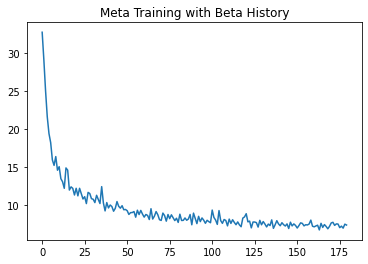

In [232]:
from math import exp, sqrt, log
def covariance_function(h, phi=0.5):
    return exp(-h/phi)

def distance_function(loc1, loc2):
    return sqrt((loc1[0] - loc2[0])**2 + (loc1[1] - loc2[1])**2)

def beta_function(meta_rate, batch_locations, seen_locations, covariance_function, distance_function):
    batch_size = len(batch_locations)
    seen_size = len(seen_locations.items())
    if seen_size == 0:
        return meta_rate
    temp = 0
    for b_loc in batch_locations:
        for s_loc, n in seen_locations.items():
            cov = covariance_function(distance_function(b_loc, s_loc))
            temp += cov * (1 + log(n))
    mean_cov = temp/(batch_size*sum(list(seen_locations.values())))
    cov_factor = exp(-mean_cov)
    bsize_factor = exp((batch_size/seen_size)**0.5)-1
    print('covariance factor:', cov_factor)
    print('batch size factor:', exp((batch_size/seen_size)**0.1)-1)
    lr = meta_rate*bsize_factor*cov_factor
    return lr

# meta train with beta
meta_history = meta_learner.meta_fit(10, batch_size=10, basic_train=True, bootstrap_train=True, use_test_for_meta=True, randomize=True,
                                    beta_function=beta_function, covariance_function=covariance_function, distance_function=distance_function)
plt.plot(meta_history)
plt.title('Meta Training with Beta History')
plt.show()

Meta lr: <tf.Variable 'learning_rate:0' shape=() dtype=float32, numpy=1e-04>
Epoch: 1 / 10  Basic training step:  1 / 8 loss:  33.434742
Meta lr: <tf.Variable 'learning_rate:0' shape=() dtype=float32, numpy=1e-04>
Epoch: 1 / 10  Basic training step:  2 / 8 loss:  33.213722
Meta lr: <tf.Variable 'learning_rate:0' shape=() dtype=float32, numpy=1e-04>
Epoch: 1 / 10  Basic training step:  3 / 8 loss:  29.951319
Meta lr: <tf.Variable 'learning_rate:0' shape=() dtype=float32, numpy=1e-04>
Epoch: 1 / 10  Basic training step:  4 / 8 loss:  30.026714
Meta lr: <tf.Variable 'learning_rate:0' shape=() dtype=float32, numpy=1e-04>
Epoch: 1 / 10  Basic training step:  5 / 8 loss:  31.6845
Meta lr: <tf.Variable 'learning_rate:0' shape=() dtype=float32, numpy=1e-04>
Epoch: 1 / 10  Basic training step:  6 / 8 loss:  25.54113
Meta lr: <tf.Variable 'learning_rate:0' shape=() dtype=float32, numpy=1e-04>
Epoch: 1 / 10  Basic training step:  7 / 8 loss:  25.593716
Meta lr: <tf.Variable 'learning_rate:0' shap

Meta lr: <tf.Variable 'learning_rate:0' shape=() dtype=float32, numpy=1e-04>
Epoch: 4 / 10  Basic training step:  7 / 8 loss:  10.926249
Meta lr: <tf.Variable 'learning_rate:0' shape=() dtype=float32, numpy=1e-04>
Epoch: 4 / 10  Basic training step:  8 / 8 loss:  10.303172
Meta lr: <tf.Variable 'learning_rate:0' shape=() dtype=float32, numpy=1e-04>
Epoch: 4 / 10 Bootstrap training step: 1 / 10 loss:  10.372353
Meta lr: <tf.Variable 'learning_rate:0' shape=() dtype=float32, numpy=1e-04>
Epoch: 4 / 10 Bootstrap training step: 2 / 10 loss:  10.152141
Meta lr: <tf.Variable 'learning_rate:0' shape=() dtype=float32, numpy=1e-04>
Epoch: 4 / 10 Bootstrap training step: 3 / 10 loss:  10.60841
Meta lr: <tf.Variable 'learning_rate:0' shape=() dtype=float32, numpy=1e-04>
Epoch: 4 / 10 Bootstrap training step: 4 / 10 loss:  10.358205
Meta lr: <tf.Variable 'learning_rate:0' shape=() dtype=float32, numpy=1e-04>
Epoch: 4 / 10 Bootstrap training step: 5 / 10 loss:  10.833624
Meta lr: <tf.Variable 'lear

Meta lr: <tf.Variable 'learning_rate:0' shape=() dtype=float32, numpy=1e-04>
Epoch: 7 / 10 Bootstrap training step: 5 / 10 loss:  8.719534
Meta lr: <tf.Variable 'learning_rate:0' shape=() dtype=float32, numpy=1e-04>
Epoch: 7 / 10 Bootstrap training step: 6 / 10 loss:  8.721205
Meta lr: <tf.Variable 'learning_rate:0' shape=() dtype=float32, numpy=1e-04>
Epoch: 7 / 10 Bootstrap training step: 7 / 10 loss:  8.338217
Meta lr: <tf.Variable 'learning_rate:0' shape=() dtype=float32, numpy=1e-04>
Epoch: 7 / 10 Bootstrap training step: 8 / 10 loss:  8.155735
Meta lr: <tf.Variable 'learning_rate:0' shape=() dtype=float32, numpy=1e-04>
Epoch: 7 / 10 Bootstrap training step: 9 / 10 loss:  8.515142
Meta lr: <tf.Variable 'learning_rate:0' shape=() dtype=float32, numpy=1e-04>
Epoch: 7 / 10 Bootstrap training step: 10 / 10 loss:  8.222095
Meta lr: <tf.Variable 'learning_rate:0' shape=() dtype=float32, numpy=1e-04>
Epoch: 8 / 10  Basic training step:  1 / 8 loss:  8.19908
Meta lr: <tf.Variable 'learnin

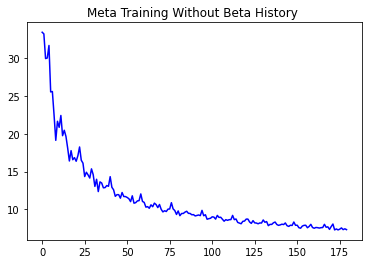

In [214]:
MDN_model_wo_beta = model_generator()
inner_optimizer_wob = tf.keras.optimizers.Adam(0.0001)
meta_optimizer_wob = tf.keras.optimizers.Adam(0.0001)
meta_learner_wo_beta = MetaSGD(MDN_model_wo_beta, gamma_loss,  meta_optimizer_wob, inner_step, inner_optimizer_wob, taskextractor)
# meta train
meta_history_wob = meta_learner_wo_beta.meta_fit(10, batch_size=10, basic_train=True, bootstrap_train=True, use_test_for_meta=True, randomize=True)
plt.plot(meta_history_wob, "-b", label="without beta")
plt.title('Meta Training Without Beta History ')
plt.show()

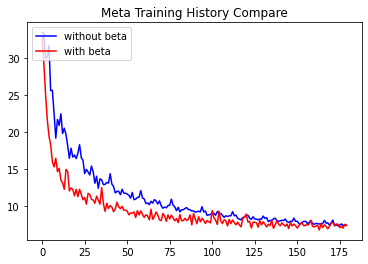

In [233]:
plt.plot(meta_history_wob, "-b", label="without beta")
plt.plot(meta_history, "-r", label="with beta")
plt.legend(loc="upper left")
plt.title('Meta Training History Compare')
plt.show()

In [55]:
meta_learner.meta_model.set_weights(meta_weights)

In [16]:
meta_weights = meta_learner.meta_model.get_weights()
trained_meta_model = meta_learner.meta_model
optimizer = tf.keras.optimizers.Adam(0.000001)
trained_meta_model.compile(optimizer=optimizer, loss=gamma_loss)
meta_history_fine_tune = trained_meta_model.fit(train_x, train_y, epochs=30, validation_data=[test_x, test_y])
meta_learner.meta_model.set_weights(meta_weights)

Epoch 1/30
16/16 [==============================] - 12s 97ms/step - loss: 5.9748 - val_loss: 6.7861
Epoch 2/30
16/16 [==============================] - 1s 31ms/step - loss: 5.9655 - val_loss: 6.4503
Epoch 3/30
16/16 [==============================] - 1s 31ms/step - loss: 6.0707 - val_loss: 6.3228
Epoch 4/30
16/16 [==============================] - 0s 31ms/step - loss: 6.0438 - val_loss: nan
Epoch 5/30
16/16 [==============================] - 0s 31ms/step - loss: 5.9490 - val_loss: nan
Epoch 6/30
16/16 [==============================] - 0s 31ms/step - loss: 5.9490 - val_loss: nan
Epoch 7/30
16/16 [==============================] - 1s 31ms/step - loss: 5.9713 - val_loss: nan
Epoch 8/30
16/16 [==============================] - 0s 31ms/step - loss: 5.9675 - val_loss: nan
Epoch 9/30
16/16 [==============================] - 1s 31ms/step - loss: 5.9840 - val_loss: nan
Epoch 10/30
16/16 [==============================] - 1s 31ms/step - loss: 5.9684 - val_loss: nan
Epoch 11/30
16/16 [==========

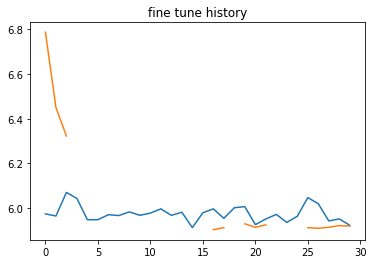

In [17]:
plot_history(meta_history_fine_tune, 'fine tune history')

In [39]:
trained_meta_model = meta_learner.meta_model
untrainded_weights = trained_meta_model.get_weights()

In [42]:
loc1 = [1, 1]
loc2 = [2, 2]
(loc1[0] - loc2[0])**2 + (loc1[1] - loc2[1])**2

2

In [46]:
for i, j in a.items():
    print(i, j)

a 1
b 2


Text(0.5, 1.0, 'Meta Training History')

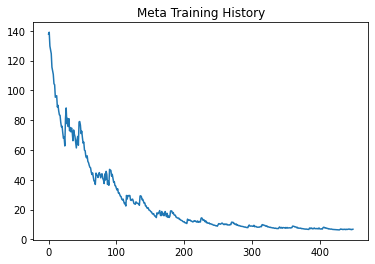

In [66]:
plt.plot(meta_history)
plt.title('Meta Training History')

In [69]:
trained_meta_model = meta_learner.meta_model
optimizer = tf.keras.optimizers.Adam(0.0000001)
trained_meta_model.compile(optimizer=optimizer, loss=gamma_loss)
trained_meta_model.summary()

Model: "model_24"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_148 (InputLayer)         [(None, 10, 1, 3, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv_lstm2d_72 (ConvLSTM2D)    (None, 10, 1, 2, 20  3760        ['input_148[0][0]']              
                                )                                                                 
                                                                                                  
 conv_lstm2d_73 (ConvLSTM2D)    (None, 10, 1, 1, 20  6480        ['conv_lstm2d_72[1][0]']         
                                )                                                          

In [31]:
meta_history_fine_tune = trained_meta_model.fit(train_x, train_y, epochs=10)

Epoch 1/10
15/15 [==============================] - 0s 31ms/step - loss: 5.7476
Epoch 2/10
15/15 [==============================] - 0s 31ms/step - loss: 5.7670
Epoch 3/10
15/15 [==============================] - 0s 31ms/step - loss: 5.7426
Epoch 4/10
15/15 [==============================] - 0s 31ms/step - loss: 5.8128
Epoch 5/10
15/15 [==============================] - 0s 29ms/step - loss: 5.7806
Epoch 6/10
15/15 [==============================] - 0s 28ms/step - loss: 5.8076
Epoch 7/10
15/15 [==============================] - 0s 28ms/step - loss: 5.8419
Epoch 8/10
15/15 [==============================] - 0s 28ms/step - loss: 5.8233
Epoch 9/10
15/15 [==============================] - 0s 28ms/step - loss: 5.8088
Epoch 10/10
15/15 [==============================] - 0s 28ms/step - loss: 5.7748


## 4. Debug Downscaler

In [72]:
reload(probdownscale.Downscaler)
from probdownscale.Downscaler import Downscaler


In [159]:
downscaler = Downscaler(meta_learner, components, test_m_data)
optimizer = tf.keras.optimizers.Adam(0.0000001)
downscaled_data = downscaler.downscale(30, optimizer, n_sample=100)

Epoch 1/30
21/21 [==============================] - 12s 70ms/step - loss: 7.0227
Epoch 2/30
21/21 [==============================] - 1s 70ms/step - loss: 6.8977
Epoch 3/30
21/21 [==============================] - 2s 75ms/step - loss: 6.9414
Epoch 4/30
21/21 [==============================] - 2s 86ms/step - loss: 6.9062
Epoch 5/30
21/21 [==============================] - 2s 86ms/step - loss: 6.9783
Epoch 6/30
21/21 [==============================] - 2s 85ms/step - loss: 6.9534
Epoch 7/30
21/21 [==============================] - 2s 86ms/step - loss: 6.9184
Epoch 8/30
21/21 [==============================] - 2s 86ms/step - loss: 6.8386
Epoch 9/30
21/21 [==============================] - 2s 91ms/step - loss: 6.9550
Epoch 10/30
21/21 [==============================] - 2s 89ms/step - loss: 6.9486
Epoch 11/30
21/21 [==============================] - 2s 88ms/step - loss: 6.9090
Epoch 12/30
21/21 [==============================] - 2s 86ms/step - loss: 6.9085
Epoch 13/30
21/21 [=================

21/21 [==============================] - 2s 84ms/step - loss: 6.9905
Epoch 24/30
21/21 [==============================] - 2s 83ms/step - loss: 6.9435
Epoch 25/30
21/21 [==============================] - 2s 82ms/step - loss: 6.8508
Epoch 26/30
21/21 [==============================] - 2s 83ms/step - loss: 6.9873
Epoch 27/30
21/21 [==============================] - 2s 83ms/step - loss: 6.8902
Epoch 28/30
21/21 [==============================] - 2s 83ms/step - loss: 6.7896
Epoch 29/30
21/21 [==============================] - 2s 85ms/step - loss: 6.8500
Epoch 30/30
21/21 [==============================] - 2s 86ms/step - loss: 6.8534
Epoch 1/30
21/21 [==============================] - 2s 82ms/step - loss: 6.7637
Epoch 2/30
21/21 [==============================] - 2s 89ms/step - loss: 6.6975
Epoch 3/30
21/21 [==============================] - 2s 83ms/step - loss: 6.7411
Epoch 4/30
21/21 [==============================] - 2s 83ms/step - loss: 6.8505
Epoch 5/30
21/21 [==========================

21/21 [==============================] - 2s 83ms/step - loss: 6.8563
Epoch 16/30
21/21 [==============================] - 2s 84ms/step - loss: 6.7874
Epoch 17/30
21/21 [==============================] - 2s 83ms/step - loss: 6.7972
Epoch 18/30
21/21 [==============================] - 2s 83ms/step - loss: 6.7755
Epoch 19/30
21/21 [==============================] - 2s 83ms/step - loss: 6.8277
Epoch 20/30
21/21 [==============================] - 2s 84ms/step - loss: 6.9009
Epoch 21/30
21/21 [==============================] - 2s 85ms/step - loss: 6.7628
Epoch 22/30
21/21 [==============================] - 2s 83ms/step - loss: 6.8096
Epoch 23/30
21/21 [==============================] - 2s 84ms/step - loss: 6.8575
Epoch 24/30
21/21 [==============================] - 2s 84ms/step - loss: 6.8298
Epoch 25/30
21/21 [==============================] - 2s 84ms/step - loss: 6.8247
Epoch 26/30
21/21 [==============================] - 2s 84ms/step - loss: 6.8462
Epoch 27/30
21/21 [=====================

21/21 [==============================] - 2s 97ms/step - loss: 6.6485
Epoch 8/30
21/21 [==============================] - 2s 101ms/step - loss: 6.6711
Epoch 9/30
21/21 [==============================] - 2s 102ms/step - loss: 6.7515
Epoch 10/30
21/21 [==============================] - 2s 104ms/step - loss: 6.6153
Epoch 11/30
21/21 [==============================] - 2s 98ms/step - loss: 6.8107
Epoch 12/30
21/21 [==============================] - 2s 97ms/step - loss: 6.6196
Epoch 13/30
21/21 [==============================] - 2s 96ms/step - loss: 6.6304
Epoch 14/30
21/21 [==============================] - 2s 97ms/step - loss: 6.8068
Epoch 15/30
21/21 [==============================] - 2s 97ms/step - loss: 6.7083
Epoch 16/30
21/21 [==============================] - 2s 96ms/step - loss: 6.6269
Epoch 17/30
21/21 [==============================] - 2s 96ms/step - loss: 6.6286
Epoch 18/30
21/21 [==============================] - 2s 96ms/step - loss: 6.5991
Epoch 19/30
21/21 [====================

21/21 [==============================] - 2s 97ms/step - loss: 6.6531
Epoch 30/30
21/21 [==============================] - 2s 97ms/step - loss: 6.6686
Epoch 1/30
21/21 [==============================] - 2s 96ms/step - loss: 6.5871
Epoch 2/30
21/21 [==============================] - 2s 96ms/step - loss: 6.6895
Epoch 3/30
21/21 [==============================] - 2s 114ms/step - loss: 6.5290
Epoch 4/30
21/21 [==============================] - 2s 105ms/step - loss: 6.5247
Epoch 5/30
21/21 [==============================] - 2s 97ms/step - loss: 6.7003
Epoch 6/30
21/21 [==============================] - 2s 96ms/step - loss: 6.5961
Epoch 7/30
21/21 [==============================] - 2s 96ms/step - loss: 6.6194
Epoch 8/30
21/21 [==============================] - 2s 97ms/step - loss: 6.6243
Epoch 9/30
21/21 [==============================] - 2s 96ms/step - loss: 6.6296
Epoch 10/30
21/21 [==============================] - 2s 97ms/step - loss: 6.6291
Epoch 11/30
21/21 [============================

21/21 [==============================] - 2s 96ms/step - loss: 6.8289
Epoch 22/30
21/21 [==============================] - 2s 98ms/step - loss: 6.8809
Epoch 23/30
21/21 [==============================] - 2s 97ms/step - loss: 6.6907
Epoch 24/30
21/21 [==============================] - 2s 97ms/step - loss: 6.8984
Epoch 25/30
21/21 [==============================] - 2s 97ms/step - loss: 6.7678
Epoch 26/30
21/21 [==============================] - 2s 97ms/step - loss: 6.9762
Epoch 27/30
21/21 [==============================] - 2s 96ms/step - loss: 6.8849
Epoch 28/30
21/21 [==============================] - 2s 97ms/step - loss: 6.8757
Epoch 29/30
21/21 [==============================] - 2s 97ms/step - loss: 6.8232
Epoch 30/30
21/21 [==============================] - 2s 96ms/step - loss: 6.8361
Epoch 1/30
21/21 [==============================] - 2s 95ms/step - loss: 6.7140
Epoch 2/30
21/21 [==============================] - 2s 96ms/step - loss: 6.8068
Epoch 3/30
21/21 [========================

21/21 [==============================] - 2s 96ms/step - loss: 6.9262
Epoch 14/30
21/21 [==============================] - 2s 97ms/step - loss: 6.8093
Epoch 15/30
21/21 [==============================] - 2s 97ms/step - loss: 6.8368
Epoch 16/30
21/21 [==============================] - 2s 97ms/step - loss: 6.7053
Epoch 17/30
21/21 [==============================] - 2s 97ms/step - loss: 6.8119
Epoch 18/30
21/21 [==============================] - 2s 97ms/step - loss: 6.8337
Epoch 19/30
21/21 [==============================] - 2s 97ms/step - loss: 6.9215
Epoch 20/30
21/21 [==============================] - 2s 96ms/step - loss: 6.7626
Epoch 21/30
21/21 [==============================] - 2s 97ms/step - loss: 6.7700
Epoch 22/30
21/21 [==============================] - 2s 97ms/step - loss: 6.7794
Epoch 23/30
21/21 [==============================] - 2s 102ms/step - loss: 6.7941
Epoch 24/30
21/21 [==============================] - 2s 97ms/step - loss: 6.6734
Epoch 25/30
21/21 [====================

Epoch 5/30
21/21 [==============================] - 2s 97ms/step - loss: 6.4791
Epoch 6/30
21/21 [==============================] - 2s 97ms/step - loss: 6.4530
Epoch 7/30
21/21 [==============================] - 2s 96ms/step - loss: 6.5080
Epoch 8/30
21/21 [==============================] - 2s 97ms/step - loss: 6.5040
Epoch 9/30
21/21 [==============================] - 2s 96ms/step - loss: 6.4554
Epoch 10/30
21/21 [==============================] - 2s 98ms/step - loss: 6.4345
Epoch 11/30
21/21 [==============================] - 2s 97ms/step - loss: 6.4791
Epoch 12/30
21/21 [==============================] - 2s 97ms/step - loss: 6.3637
Epoch 13/30
21/21 [==============================] - 2s 97ms/step - loss: 6.4124
Epoch 14/30
21/21 [==============================] - 2s 97ms/step - loss: 6.4851
Epoch 15/30
21/21 [==============================] - 2s 97ms/step - loss: 6.5740
Epoch 16/30
21/21 [==============================] - 2s 98ms/step - loss: 6.4421
Epoch 17/30
21/21 [==============

21/21 [==============================] - 2s 96ms/step - loss: 6.5609
Epoch 28/30
21/21 [==============================] - 2s 97ms/step - loss: 6.4259
Epoch 29/30
21/21 [==============================] - 2s 102ms/step - loss: 6.4353
Epoch 30/30
21/21 [==============================] - 2s 98ms/step - loss: 6.4475
Epoch 1/30
21/21 [==============================] - 2s 96ms/step - loss: 6.6090
Epoch 2/30
21/21 [==============================] - 2s 97ms/step - loss: 6.6123
Epoch 3/30
21/21 [==============================] - 2s 97ms/step - loss: 6.7081
Epoch 4/30
21/21 [==============================] - 2s 97ms/step - loss: 6.6464
Epoch 5/30
21/21 [==============================] - 2s 97ms/step - loss: 6.5214
Epoch 6/30
21/21 [==============================] - 2s 97ms/step - loss: 6.6349
Epoch 7/30
21/21 [==============================] - 2s 97ms/step - loss: 6.5889
Epoch 8/30
21/21 [==============================] - 2s 97ms/step - loss: 6.5293
Epoch 9/30
21/21 [=============================

21/21 [==============================] - 2s 96ms/step - loss: 6.6256
Epoch 20/30
21/21 [==============================] - 2s 96ms/step - loss: 6.6377
Epoch 21/30
21/21 [==============================] - 2s 97ms/step - loss: 6.6797
Epoch 22/30
21/21 [==============================] - 2s 97ms/step - loss: 6.6062
Epoch 23/30
21/21 [==============================] - 2s 98ms/step - loss: 6.7216
Epoch 24/30
21/21 [==============================] - 2s 97ms/step - loss: 6.6883
Epoch 25/30
21/21 [==============================] - 2s 108ms/step - loss: 6.6139
Epoch 26/30
21/21 [==============================] - 2s 107ms/step - loss: 6.6890
Epoch 27/30
21/21 [==============================] - 2s 98ms/step - loss: 6.7117
Epoch 28/30
21/21 [==============================] - 2s 97ms/step - loss: 6.7930
Epoch 29/30
21/21 [==============================] - 2s 98ms/step - loss: 6.6857
Epoch 30/30
21/21 [==============================] - 2s 97ms/step - loss: 6.6890
Epoch 1/30
21/21 [====================

21/21 [==============================] - 2s 98ms/step - loss: 6.4851
Epoch 12/30
21/21 [==============================] - 2s 97ms/step - loss: 6.4124
Epoch 13/30
21/21 [==============================] - 2s 97ms/step - loss: 6.3989
Epoch 14/30
21/21 [==============================] - 2s 97ms/step - loss: 6.3256
Epoch 15/30
21/21 [==============================] - 2s 98ms/step - loss: 6.3388
Epoch 16/30
21/21 [==============================] - 2s 97ms/step - loss: 6.3820
Epoch 17/30
21/21 [==============================] - 2s 97ms/step - loss: 6.3881
Epoch 18/30
21/21 [==============================] - 2s 98ms/step - loss: 6.4598
Epoch 19/30
21/21 [==============================] - 2s 98ms/step - loss: 6.3920
Epoch 20/30
21/21 [==============================] - 2s 97ms/step - loss: 6.4376
Epoch 21/30
21/21 [==============================] - 2s 98ms/step - loss: 6.4535
Epoch 22/30
21/21 [==============================] - 2s 97ms/step - loss: 6.5493
Epoch 23/30
21/21 [=====================

21/21 [==============================] - 2s 98ms/step - loss: 6.5827
Epoch 4/30
21/21 [==============================] - 2s 100ms/step - loss: 6.6328
Epoch 5/30
21/21 [==============================] - 2s 99ms/step - loss: 6.6145
Epoch 6/30
21/21 [==============================] - 2s 97ms/step - loss: 6.5082
Epoch 7/30
21/21 [==============================] - 2s 97ms/step - loss: 6.5270
Epoch 8/30
21/21 [==============================] - 2s 97ms/step - loss: 6.5518
Epoch 9/30
21/21 [==============================] - 2s 98ms/step - loss: 6.3992
Epoch 10/30
21/21 [==============================] - 2s 97ms/step - loss: 6.5685
Epoch 11/30
21/21 [==============================] - 2s 98ms/step - loss: 6.4431
Epoch 12/30
21/21 [==============================] - 2s 98ms/step - loss: 6.5687
Epoch 13/30
21/21 [==============================] - 2s 97ms/step - loss: 6.5121
Epoch 14/30
21/21 [==============================] - 2s 98ms/step - loss: 6.4910
Epoch 15/30
21/21 [==========================

21/21 [==============================] - 2s 103ms/step - loss: 6.7847
Epoch 26/30
21/21 [==============================] - 2s 97ms/step - loss: 6.8149
Epoch 27/30
21/21 [==============================] - 2s 97ms/step - loss: 6.6020
Epoch 28/30
21/21 [==============================] - 2s 96ms/step - loss: 6.7317
Epoch 29/30
21/21 [==============================] - 2s 97ms/step - loss: 6.5175
Epoch 30/30
21/21 [==============================] - 2s 97ms/step - loss: 6.6021
Epoch 1/30
21/21 [==============================] - 2s 95ms/step - loss: 6.6417
Epoch 2/30
21/21 [==============================] - 2s 97ms/step - loss: 6.5846
Epoch 3/30
21/21 [==============================] - 2s 97ms/step - loss: 6.7230
Epoch 4/30
21/21 [==============================] - 2s 97ms/step - loss: 6.6437
Epoch 5/30
21/21 [==============================] - 2s 97ms/step - loss: 6.5707
Epoch 6/30
21/21 [==============================] - 2s 98ms/step - loss: 6.7322
Epoch 7/30
21/21 [===========================

21/21 [==============================] - 2s 99ms/step - loss: 6.3644
Epoch 18/30
21/21 [==============================] - 2s 97ms/step - loss: 6.3818
Epoch 19/30
21/21 [==============================] - 2s 102ms/step - loss: 6.3846
Epoch 20/30
21/21 [==============================] - 2s 97ms/step - loss: 6.4347
Epoch 21/30
21/21 [==============================] - 2s 97ms/step - loss: 6.3777
Epoch 22/30
21/21 [==============================] - 2s 97ms/step - loss: 6.4943
Epoch 23/30
21/21 [==============================] - 2s 97ms/step - loss: 6.4582
Epoch 24/30
21/21 [==============================] - 2s 98ms/step - loss: 6.3646
Epoch 25/30
21/21 [==============================] - 2s 96ms/step - loss: 6.5810
Epoch 26/30
21/21 [==============================] - 2s 97ms/step - loss: 6.3439
Epoch 27/30
21/21 [==============================] - 2s 96ms/step - loss: 6.3246
Epoch 28/30
21/21 [==============================] - 2s 97ms/step - loss: 6.3826
Epoch 29/30
21/21 [====================

21/21 [==============================] - 2s 103ms/step - loss: 6.5328
Epoch 9/30
21/21 [==============================] - 2s 94ms/step - loss: 6.4151
Epoch 10/30
21/21 [==============================] - 2s 95ms/step - loss: 6.5300
Epoch 11/30
21/21 [==============================] - 2s 94ms/step - loss: 6.4497
Epoch 12/30
21/21 [==============================] - 2s 95ms/step - loss: 6.4424
Epoch 13/30
21/21 [==============================] - 2s 96ms/step - loss: 6.4149
Epoch 14/30
21/21 [==============================] - 2s 95ms/step - loss: 6.4610
Epoch 15/30
21/21 [==============================] - 2s 95ms/step - loss: 6.3533
Epoch 16/30
21/21 [==============================] - 2s 95ms/step - loss: 6.4430
Epoch 17/30
21/21 [==============================] - 2s 95ms/step - loss: 6.5303
Epoch 18/30
21/21 [==============================] - 2s 95ms/step - loss: 6.4751
Epoch 19/30
21/21 [==============================] - 2s 94ms/step - loss: 6.4000
Epoch 20/30
21/21 [=====================

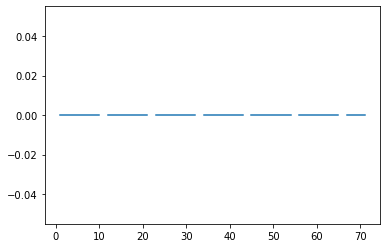

In [154]:
def point_evaluate(pred_data, true_data):
    if pred_data.shape != true_data.shape:
        print('Please check data consistency!')
        raise ValueError
    RMSE_out = np.zeros(pred_data.shape[1:])
    #R2_out = np.zeros(pred_data.shape[1:])
    for i in range(pred_data.shape[1]):
        for j in range(pred_data.shape[2]):
            if np.isnan(true_data[0, i, j]):
                RMSE_out[i, j] = float("nan")
                #R2_out[i, j] = float("nan")
            else:
                RMSE_out[i ,j] = np.square(pred_data[: ,i ,j] - true_data[: ,i ,j]).mean()
                #R2_out[i ,j], _ = nc_process.rsquared(pred_data[: ,i ,j], true_data[: ,i ,j])
    return RMSE_out


def image_evaluate(pred_data, true_data):
    if pred_data.shape != true_data.shape:
        print('Please check data consistency!')
        raise ValueError
    length = np.prod(pred_data.shape[1:])
    r2_list = np.zeros(pred_data.shape[0])
    rmse_list = np.zeros(pred_data.shape[0])
    filter = ~np.isnan(pred_data[0].reshape(length))
    for i in range(pred_data.shape[0]):
        r2_list[i],_ = nc_process.rsquared(pred_data[i].reshape(length)[filter], true_data[i].reshape(length)[filter])
        rmse_list[i] = np.nanmean(np.square(pred_data[i] - true_data[i]))
    return rmse_list, r2_list

In [162]:
downscaled_data[:, 14, 14]

array([7.45737791, 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 4.86772442, 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 4.90784502, 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 4.9520936 , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 4.96188164,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       4.77881289, 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 5.15625381, 0.        , 0.        , 0.        ,
       0.        , 0.        ])

In [26]:
[meta_learner.task_extractor.h_lats[int(i*meta_learner.task_extractor.task_dim[0])] for i in range(int(len(meta_learner.task_extractor.h_lats)//meta_learner.task_extractor.task_dim[0]))]

[10.9375,
 11.125,
 11.3125,
 11.5,
 11.6875,
 11.875,
 12.0625,
 12.25,
 12.4375,
 12.625]

In [69]:
init[0][0, -3:, 0, :, :].shape

(3, 3, 3)